Submitted by:

Lior Maltz - 318307923
Alon Papini - 205815962

**Imports cell**

In [1]:
# Object imports
import numpy as np
import pandas as pd
import torch

# Image handle imports
import cv2
from PIL import Image

# Data handle imports
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

# Plot and presentation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Others
import torch.nn as nn
from torchvision import transforms
import os
import zipfile
import random
import io
import time

In [2]:
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The file 'all_data_info.csv' stores all the information about the data we will use in our Siamese model.
With a CSV reader variable we could investigate the data, and from there decide how to build the model.

In [3]:
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')
# Look at the first 20 images of the data
all_data_csv.head(20)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


Here we'll do initial parsing of the data to better understand what we're up against.

In [4]:
total_num = len(all_data_csv)
train_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_only'])
test_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'test_only'])
train_and_test_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_and_test'])

artist_num = len(all_data_csv['artist'].unique())
genres_num = len(all_data_csv["genre"].dropna().unique())

pixelsx_mean = all_data_csv["pixelsx"].mean()
pixelsx_var = all_data_csv["pixelsx"].var()
pixelsx_max = int(all_data_csv["pixelsx"].max())
pixelsx_min = int(all_data_csv["pixelsx"].min())

pixelsy_mean = all_data_csv["pixelsy"].mean()
pixelsy_var = all_data_csv["pixelsy"].var()
pixelsy_max = int(all_data_csv["pixelsy"].max())
pixelsy_min = int(all_data_csv["pixelsy"].min())

average_paints_per_artist = all_data_csv['artist'].value_counts().mean()


#print(all_data_csv['artist'].value_counts())
# To check number of images with not NaN genre value
#Nan_genres_num = len(all_data_csv.loc[pd.isna(all_data_csv["genre"]) == False])

print(f'Total number of images in the data: {total_num}')
print(f'The Split of the data between Train only/Train and Test/ Test only is: {train_only_num}/{train_and_test_num}/{test_only_num}\n')

print(f'Number of different genres: {genres_num}')
print(f'Average paints per artist in this set: {average_paints_per_artist:.2f}\n')

print(f'The average size of X axis per image is {pixelsx_mean:.2f} pixel, and average size of Y axis per image is {pixelsy_mean:.2f}')
print(f'The highest (X, Y) measurements are ({pixelsx_max}, {pixelsy_max}), and the lowest are ({pixelsx_min}, {pixelsy_min})')
print(f'The variances of the axis measurements are ({pixelsx_var:.2f}, {pixelsy_var:.2f})')

Total number of images in the data: 103250
The Split of the data between Train only/Train and Test/ Test only is: 14164/86150/2936

Number of different genres: 42
Average paints per artist in this set: 44.52

The average size of X axis per image is 960.81 pixel, and average size of Y axis per image is 984.09
The highest (X, Y) measurements are (25528, 9541), and the lowest are (200, 162)
The variances of the axis measurements are (355538.29, 390799.19)


Next up, a presentation of some random images from the dataset.
Note: Not all the images are presented in their correct color format.

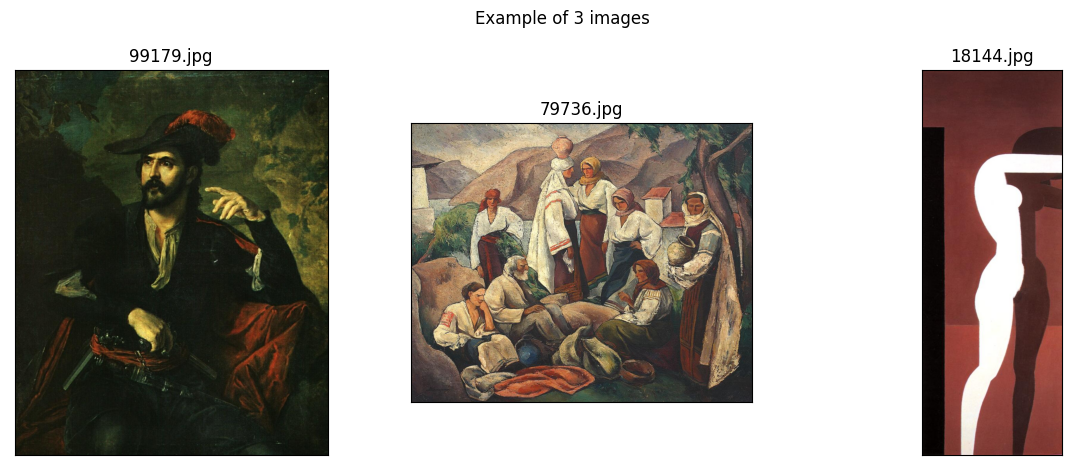

In [5]:
# Example:
img_folder_path = '../Data/Images/training/train'

plt.figure(figsize=(15,5))

for i in range(1,4):
    # choose a image file randomly from the training data
    random_image_name = random.choice(os.listdir(img_folder_path))

    # unzip image with color conversion
    archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
    image_data = archive.open("train/" + random_image_name)
    image = Image.open(image_data)

    # presenting the 3 images in a row
    plt.subplot(1, 3, i)
    plt.title(random_image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))

plt.suptitle(f"Example of {3} images", y=1.001)
plt.show()

In this cell we made some attempts to properly display images, with their RGB/BGR channels and all.

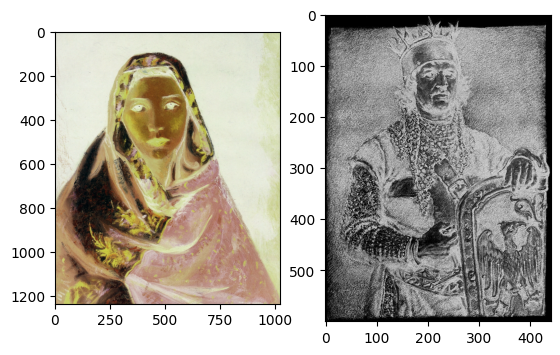

In [6]:
import imghdr
#image = cv2.imread('../Data/Images/training/train/95010.jpg')
#plt.imshow(image)
#plt.show()
try:
    for i in range(1):

        archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
        img_path = 'train/'
        #imgdata = archive.open(img_path+'75861.jpg')
        #print(imghdr.what("../Data/Images/training/train/"+'75861.jpg'))
        #print(img.getType())
        #image = Image.open(image_data)
        #print(image.format)
        image = cv2.imread("../Data/Images/training/train/"+"42790.jpg")
        image2 = cv2.imread("../Data/Images/training/train/"+"75861.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = 255 - image[:,:]
        image2 = 255 - image2[:,:]
        #print(imgdata)
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
    plt.show()
except Image.DecompressionBombError:
    print("error")
#try:
#    image = cv2.imread('../Data/Images/training/train/72255.jpg')
#    #plt.imshow(image)
#    #plt.show()
#except Image.DecompressionBombError:
#    print("error")

One of the things we tried to help simplify / shorten the training duration is to fix the resolution of all images to one specific size, usually smaller than their original size.

In [7]:
def resolution_fixture(path_from, path_to, file_name, new_res=256):
    images = []
    i1 = 0
    archive = zipfile.ZipFile(path_from + '/' + file_name + '.Zip', 'r')
    # first we extract all the files from a given zip file and then store them in a list of items in the form of [file_name, file_in bytes]
    for current_file_path in archive.namelist():
        if (i1) % 500 == 0:
            print(f"{i1} images processed")
        i1 += 1
        # separate the names
        if not "jpg" in current_file_path:
            continue
        else:
            image_name = current_file_path[len(file_name)+1:]

        try:

            file_object = io.BytesIO()
            image_data = archive.open(current_file_path)
            image = Image.open(image_data)
            tensor_image = transforms.Compose([transforms.ToTensor(), transforms.Resize((new_res, new_res))])(image)
            image = transforms.ToPILImage()(tensor_image)
            # save in file object buffer
            image.save(file_object, 'PNG')
            image.close()
            images.append([image_name, file_object])

        except Image.DecompressionBombError:
                print(f"DecompressionBombError in file {image_name}")
        except Exception as e:
            print(f" Error received in image {image_name}")
            print(f" Error massage: {str(e)}")


    #zip_file_bytes_io = io.BytesIO()
    #zip_file = zipfile.ZipFile(path_to + '/' + file_name + '.zip', 'w')

    with zipfile.ZipFile(path_to + '/' + file_name + '_' + str(new_res) + '.zip', 'w') as zip_obj:
        for image_name, bytes_stream in images:
            zip_obj.writestr(file_name + '/' + image_name, bytes_stream.getvalue())


# if True - Run the zip creation code of scaled resolution images
if False:
    for i in range (2,7):
        path_from = "../Data/Zips"
        path_to = "../Data/Zips/Fixed_Zips"
        file_name = "train_" + str(i)
        new_res = 256
        resolution_fixture(path_from, path_to, file_name, new_res)

First, We should classify our data by train and test data

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# if the data frame is not yet defined we can extract it from files if it is already stored there.
# if the data frame is not saved in files either, we will make it from scratch.
if ("train_data_frame" not in globals()) and (not os.path.isfile("../Data/Variables/train_data_frame.pkl")):
    # We will train our model only with artists that have more than 10 paintings labeled under their name.
    paints_per_painter = all_data_csv['artist'].value_counts()
    #a =  all_data_csv.items()
    #paints_per_painter = all_data_csv.items()['artist'].value_counts()
    #print(paints_per_painter)
    actual_artist_list = [paints_per_painter.index[i] for i in range(len(paints_per_painter)) if paints_per_painter[i] > 10]

    # Here we are classifying the data by train and test paintings, as they presented in the CSV file.
    # We choose only the paintings of artists with more than 10 paintings to their name for the sake of easier training.
    train_data_frame = pd.DataFrame({})
    test_data_frame = pd.DataFrame({})
    i1 = 0
    for artist in actual_artist_list:
        i1 += 1
        artist_data = all_data_csv[(all_data_csv['artist']==artist)]
        artist_train_data = artist_data.loc[(artist_data.in_train == True)]
        artist_test_data = artist_data.loc[(artist_data.in_train == False)]
        train_data_frame = pd.concat([train_data_frame, artist_train_data])
        test_data_frame = pd.concat([test_data_frame, artist_test_data])

    train_data_frame.to_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame.to_pickle("../Data/Variables/test_data_frame.pkl")

else:
    train_data_frame = pd.read_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame = pd.read_pickle("../Data/Variables/test_data_frame.pkl")

These are dataloader classes, separate for each type of loss function: Contrastive and Triplet.
Either way, these dataloaders will be used to for the models to properly interact with the data.

In [9]:
# An idea is to inherit from a root class for the definition of the SingleDataSet and TripletDataSet loss classes.
class RootDataSet:
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.data_frame = data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"
            self.train_zip_name += '/'

        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        if is_train:
            self.filter_data_frame(min_paints_artist=20, max_paints_artist=10000, most_frequent=None)

        self.train_images_files = self.data_frame.iloc[:, 11].values
        self.train_labels = self.data_frame.iloc[:, 0].values
        self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(150, 15)

    # With this function we choose only artists with a set range of paintings to their name.
    def filter_data_frame(self, min_paints_artist, max_paints_artist, most_frequent = None):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = self.data_frame.loc[self.data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()[:most_frequent]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > min_paints_artist].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < max_paints_artist].index)]
        self.data_frame = self.data_frame.reset_index(drop=True)

    # With this function we choose n images from a number of artists with the largest number of paintings to be visualized in the 3D graphs we plot later in the notebook, when we train and evaluate models.
    def choose_n_to_visualization(self, n, num_artist=15):
        data_frame_count = self.data_frame["artist"].value_counts()[:num_artist]
        data_frame_vis = self.data_frame[self.data_frame['artist'].isin(data_frame_count.index)].reset_index(drop=True)
        train_index_vis = data_frame_vis.index.values
        train_labels_vis = data_frame_vis.iloc[:, 0].values

        indices = np.random.choice(train_index_vis, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = train_labels_vis[index]

            image = self.toTensor(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]
            image = self.normalize(image)

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels


    def remove_validation_data(self, data_to_remove):
        for i in range(len(data_to_remove)):
            data_to_remove['new_filename']
            mask = self.data_frame['new_filename'].isin(data_to_remove['new_filename'])

            # invert the mask to select the rows that should remain in df1
            self.data_frame = self.data_frame[~mask]
            self.data_frame = self.data_frame.reset_index(drop=True)

# debug stuff
#obj = RootDataSet("train", train_data_frame, fixed_res=True, res_size=256)
#obj2 = RootDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#obj.remove_validation_data(obj2.data_frame)



In [10]:
# Contrastive loss dataloader definition, inherits from RootDataSet
class SingleDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images, for both the image and the label
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            # transform the image to a specific dimension
            anchor_image = self.toTensor(anchor_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            anchor_image = self.normalize(anchor_image)

            return anchor_image, anchor_label

        # In case label = -1 it's a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, self.res_size, self.res_size), "None_label"


In [11]:
#  Double dataloader definition, inherits from RootDataSet
class DoubleDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)

    # each iteration we will bring a pair of images, and a label which indicate if they came from the same artist (1), or not (0)
    def __getitem__(self, index):
        try:

            # Extraction process of the three images for the current item
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]


            label = random.randint(0, 1)
            # choose between positive and negative
            if label:
                bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
                second_list = np.array(self.train_index[self.train_index!=index])
                second_list = second_list[bool_list]
                # In case there aren't any images in the positive list, item don't have a positive partner
                if(len(second_list) == 0):
                    raise Exception("No matching image for anchor")
                else:
                    positive_index = random.choice(second_list)

                second_file_name = self.train_images_files[positive_index]
                second_image_data = self.train_archive.open(self.train_zip_name + second_file_name)
                second_image = Image.open(second_image_data)

            else:
                second_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
                second_index = random.choice(second_list)
                second_file_name = self.train_images_files[second_index]
                second_image_data = self.train_archive.open(self.train_zip_name + second_file_name)
                second_image = Image.open(second_image_data)


            anchor_image = self.toTensor(anchor_image)
            second_image = self.toTensor(second_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if second_image.shape[0] == 1:
                second_image = torch.cat([second_image, second_image, second_image], 0)
            if second_image.shape[0] == 4:
                second_image = second_image[0:3]

            anchor_image = self.normalize(anchor_image)
            second_image = self.normalize(second_image)

            ret_tensor = torch.stack(([anchor_image, second_image]))
            return ret_tensor, float(label)

        # In case label = -1 it's a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"


## to debug
#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1


In [12]:
# inspiration from https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms
# Triplet loss dataloader definition, inherits from RootDataSet
class TripletDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        try:

            # Extraction process of the three images for the current item
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # In case there aren't any images in the positive list, item don't have a positive partner
            if(len(positive_list) == 0):
                raise Exception("No matching image for anchor")
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("Positive and anchor don't have the same label, so... Mismatch?")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("Negative and anchor have the same label, so... Mismatch?")

            anchor_image = self.toTensor(anchor_image)
            positive_image = self.toTensor(positive_image)
            negative_image = self.toTensor(negative_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            anchor_image = self.normalize(anchor_image)
            positive_image = self.normalize(positive_image)
            negative_image = self.normalize(negative_image)

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # In case label = -1 it's a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"


## to debug
#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1


The following code block was used to test how long the data loader classes took to run.

In [13]:
if False:
    start_time = time.perf_counter()

    obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
    data_loader = DataLoader(obj, batch_size=32, num_workers=0, shuffle=True)
    i = 0
    for inputs, labels in data_loader:
        #print(inputs.shape)
        #print(labels)
        if i == 63:
            break
        i += 1
        if i % 10 == 0:
            print(f"done {i}")

    end_time = time.perf_counter()
    print(f"{end_time - start_time:0.2f} seconds")


In [14]:
# An attempt at a network for the model
class Network2(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(Network2, self).__init__()
        self.criterion = TripletLoss()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.BatchNorm1d(128*28*28),
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [15]:
# An attempt at a siamese CNN that determines if paintings have an identical artist or not.
class Network(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(Network, self).__init__()
        self.criterion = TripletLoss()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [16]:
# This class calculates triplet loss. Even though PyTorch has it built-in, we still made our own version.
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean(), predictions

    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


In [17]:
# This function is the part where, given a model and a specific data loader, we compare what the model has to say about inputs belonging to the same artist or not and the ground truth.
def test_run(test_loader, model, set_type = "training"):
    attempts = 0
    successes = 0

    loss_list = []

    for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        #if (step + 1) % 5 == 0:
        if ((step + 1) % 100 == 0 and set_type != "test"):
            break

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = model.criterion.predict(anchor_out, positive_out, negative_out)
        loss_list.append(loss.cpu().detach().numpy())
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]
    success_rate = successes/attempts
    if set_type == "validation":
        print(f"Validation success rate: {(success_rate):0.2f}")
    elif set_type == "train":
        print(f"Training success rate: {(success_rate):0.2f}")
    elif set_type == "test":
        print(f"Test success rate: {(success_rate):0.2f}")
    #input("Press Enter to continue...")

    return np.mean(loss_list), success_rate


#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)

3-d visualization cell

In [18]:
from sklearn.decomposition import PCA
# This class helps generate a 3D graph, for visualization during the training stages. We do so by using PCA to get the 3 most important values that define an image.
def visualization_3d(model, data_loader_object):
    pca = PCA(n_components=3)
    batch_size = 2
    n_images = data_loader_object.n_images
    labels = data_loader_object.labels
    embedded_image_list = np.empty([0, 128])
    for i in range(0, int(len(n_images)/batch_size) - 1):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i*batch_size+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))
        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)

    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]

    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list, cmap='gist_rainbow')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

# for debugging purposes:
if False:
    model = Network().to(device)
    triplet_obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
    for i in range(5):
        visualization_3d(model, triplet_obj)

In [19]:
# This code cell has functions that help find and calculate "hard batches" - triplets such that the positive image is far away from the anchor, and the negative image is close to the anchor. Using hard batches should help us train a better model.

def get_embeddings(model, inputs, out_dim):
    inputs = inputs.to(device)
    embeddings = torch.empty(0, out_dim)
    for i in range(len(inputs)):
        embeddings = torch.cat([embeddings, model(inputs[i].to(device))], 0)
    return embeddings

# here a matrix of (batch_size, batch_size) will store the distances between all the embedding vectors
def _pairwise_distances(embeddings):
    dot_product = torch.matmul(embeddings, embeddings.t())
    square_norm = torch.diag(dot_product)
    distances = torch.unsqueeze(square_norm, 0) - 2.0 * dot_product + torch.unsqueeze(square_norm, 1)
    distances = torch.clamp(distances, min=0.0)

    return distances

# return matrix if the size (batch_size, batch_size), with True only in the cells of positive items
def _get_anchor_positive_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label == labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask

# return matrix if the size (batch_size, batch_size), with True only in the cells of negative items
def _get_anchor_negative_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label != labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask


# This code will find the hardest negative and positive for every input, and will compute with them triplet loss
def batch_hard_triplet_loss(labels, embeddings, margin):

    # Get the pair wise distance matrix
    pairwise_dist = _pairwise_distances(embeddings)

    # For each anchor, get the hardest positive (the farthest one), by filtering only the positive items with a boolean mask
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = mask_anchor_positive.to(torch.float32)
    anchor_positive_dist = mask_anchor_positive.to(device) * pairwise_dist
    # shape (batch_size, 1)
    hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)
     # For each anchor, get the hardest negative item (the closest one), by filtering only the negative items with a boolean mask
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = mask_anchor_negative.to(torch.float32)
    max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative.to(device))
    # shape (batch_size,)
    hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

    # triplet loss computations
    triplet_loss = torch.relu(hardest_positive_dist - hardest_negative_dist + margin)
    triplet_loss = torch.mean(triplet_loss)
    return triplet_loss

In [ ]:
# Initialization of several variables
epochs = 240
batch_size = 32
lr_patience = 2
lr_steps = lr_patience
min_loss = 100000000
min_validation_loss = 100000000
early_stopping_patience = 10
patience_steps = early_stopping_patience
hard_batch = False

epochs_num = 0

model = Network().to(device)
#model = Network2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)
triplet_loss = TripletLoss(0.25).to(device)

all_training_zips = ["train_1", "train_2", "train_3", "train_4", "train_5", "train_6", "train_7", "train_8", "train_9"]
validation_zip = random.choice(all_training_zips)
all_training_zips.remove(validation_zip)

validation_loader_object = TripletDataSet(validation_zip, train_data_frame, fixed_res=True, res_size=256)
validation_loader = DataLoader(validation_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

#def set_loader():

    #current_training_zip = random.choice(all_training_zips)

current_training_zip = "train"

if not hard_batch:
    train_loader_object = TripletDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
    train_loader_object.remove_validation_data(validation_loader_object.data_frame)
    train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

else:
    train_loader_object = SingleDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
    train_loader_object.remove_validation_data(validation_loader_object.data_frame)
    train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

    #return train_loader, train_loader_object

plot_training_loss_list = []
plot_training_loss_accuracy_list = []
plot_validation_loss_list = []
plot_validation_loss_accuracy_list = []

for epoch in range(epochs):
    epochs_num+= 1
    #train_loader, train_loader_object = set_loader()

    print(f"start epoch {epoch+1}")
    print(f"current learning rate is: {optimizer.param_groups[0]['lr']}")
    training_loss_list = []
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # Remember to comment this out for full training
        if (step+1) % 750 == 0:
            break
        if (step+1) % 50 == 0:
            print(step+1)

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue


        # Choose between feeding normal batches or hard batches to calculate triplet loss
        if not hard_batch:
            anchor_img = inputs[:,0,:,:,:].to(device)
            positive_img = inputs[:,1,:,:,:].to(device)
            negative_img = inputs[:,2,:,:,:].to(device)

            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)

            loss = triplet_loss(anchor_out, positive_out, negative_out)

        else:
            inputs = inputs.to(device)
            embeddings = model(inputs)
            loss = batch_hard_triplet_loss(labels, embeddings, 0.5)

        loss.backward()
        optimizer.step()

        training_loss_list.append(loss.cpu().detach().numpy())

    current_loss = np.mean(training_loss_list)
    print("Epoch: {}/{} - Training Loss: {:.2f}".format(epoch+1, epochs, current_loss))

    # Run a batch from a training set on the model, and print accuracy results
    training_loss, training_success_rate = test_run(train_loader, model, "train")

    # Run a batch from the validation set on the model, and print accuracy results
    validation_loss, validation_success_rate = test_run(validation_loader, model, "validation")
    visualization_3d(model, validation_loader_object)

    plot_training_loss_list.append(training_loss)
    plot_training_loss_accuracy_list.append(training_success_rate)
    plot_validation_loss_list.append(validation_loss)
    plot_validation_loss_accuracy_list.append(validation_success_rate)

    if validation_loss < min_validation_loss:
        min_validation_loss = validation_loss
        patience_steps = early_stopping_patience

    else:
        patience_steps -= 1
        if patience_steps == 0:
            print("Patience ran out, early stopping now...")
            break

    if current_loss < min_loss * 0.95:
            min_loss = current_loss
            lr_steps = lr_patience
    else:
        lr_steps = lr_steps - 1
        if lr_steps == 0:
            scheduler.step()
            lr_steps = lr_patience


# Plot training, validation accuracy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.plot(range(epochs_num), plot_training_loss_accuracy_list)
plt.plot(range(epochs_num), plot_validation_loss_accuracy_list)
plt.legend(['Training', 'Validation'])
plt.title("Accuracy Graph")


# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.plot(range(epochs_num), plot_training_loss_list)
plt.plot(range(epochs_num), plot_validation_loss_list)
plt.legend(['Training', 'Validation'])
plt.title("Loss Graph")

plt.suptitle("Siamese CNN")

plt.plot()

In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [ ]:
def evaluation(model):
    # prepare the test loader and send it with the examined model to the tester
    #test_loader_object = TripletDataSet("test", test_data_frame, fixed_res=True, res_size=256)
    test_loader_object = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
    test_loader = DataLoader(test_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
    test_run(test_loader, model, "test")
    # visualize the model outputs
    visualization_3d(model, test_loader_object)

if True:
    # Create a new instance of the model
    # Then we load the stored state of the model we want to evaluate
    batch_size = 16
    model = Network(3, 128)
    checkpoint = torch.load("../Data/Models/trained_model.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    evaluation(model.to(device))

In [ ]:
class SiameseNetwork_(nn.Module):
    def __init__(self, in_dim=128, out_dim=1):
        super(SiameseNetwork, self).__init__()

        embedder = Network(3, 128)
        checkpoint = torch.load("../Data/Models/trained_model.pth")
        embedder.load_state_dict(checkpoint["model_state_dict"])
        self.embedder = embedder
        for parameter in embedder.parameters():
            parameter.requires_grad = False

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.max_pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(32*61, 128)
        self.dropout = nn.Dropout(0.2)

        self.combined_fc1 = nn.Linear(256, 64)
        self.combined_fc2 = nn.Linear(64, 1)
        self.p_relu = nn.PReLU()

    def forward_once(self, x):
        x = self.embedder(x)
        x = x.view(len(x), 1, -1)
        x = self.p_relu(self.conv2(self.max_pool(self.p_relu(self.conv1(x)))))
        x = self.p_relu(self.fc1(self.dropout(self.flat(x))))
        return x

    def combined_forward(self, combined_input):
        return self.combined_fc2(self.combined_fc1(combined_input))

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return self.combined_forward(torch.cat((out1, out2), dim=1))

In [ ]:
# building siamese tester
def siamese_test_run_(test_loader, siamese_model, criterion, set_type = "training"):
    attempts = 0
    successes = 0

    loss_list = []

    for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        #if (step + 1) % 5 == 0:
        if ((step + 1) % 100 == 0 and set_type != "test"):
            break

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_imgs = inputs[:, 0, :, :, :].to(device)
        second_imgs = inputs[:, 1, :, :, :].to(device)

        outputs = siamese_model(anchor_imgs, second_imgs)

        predictions = (outputs.to("cpu") >= 0).float()
        successes += sum(predictions.cpu()).item()
        attempts += predictions.cpu().shape[0]

        loss = criterion(torch.squeeze(outputs), labels.to(device))
        loss_list.append(loss.cpu().detach().numpy())

    success_rate = successes/attempts
    if set_type == "validation":
        print(f"Validation success rate: {success_rate:0.2f}")
    elif set_type == "train":
        print(f"Training success rate: {success_rate:0.2f}")
    elif set_type == "test":
        print(f"Test success rate: {success_rate:0.2f}")
    #input("Press Enter to continue...")

    return np.mean(loss_list), success_rate



#siamese_model = SiameseNetwork().to(device)
#criterion = nn.BCEWithLogitsLoss()
#train_loader_object = DoubleDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
#training_loss, training_success_rate = siamese_test_run(train_loader, siamese_model, criterion, "train")

In [ ]:
epochs = 240
epochs_num = 0
batch_size = 32


siamese_model = SiameseNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

all_training_zips = ["train_1", "train_2", "train_3", "train_4", "train_5", "train_6"]

validation_zip = random.choice(all_training_zips)
validation_loader_object = DoubleDataSet(validation_zip, train_data_frame, fixed_res=True, res_size=256)
validation_loader = DataLoader(validation_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

all_training_zips.remove(validation_zip)
current_training_zip = random.choice(all_training_zips)
train_loader_object = DoubleDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)



plot_training_loss_list = []
plot_training_loss_accuracy_list = []
plot_validation_loss_list = []
plot_validation_loss_accuracy_list = []

for epoch in range(epochs):
    epochs_num+= 1
    #train_loader, train_loader_object = set_loader()

    print(f"start epoch {epoch+1}")
    print(f"current learning rate is: {optimizer.param_groups[0]['lr']}")
    training_loss_list = []
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if (step+1) % 2 == 0:
            break
        if (step+1) % 50 == 0:
            print(step+1)

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_imgs = inputs[:,0,:,:,:].to(device)
        second_imgs = inputs[:,1,:,:,:].to(device)
        labels = labels.to(device)
        outputs = siamese_model(anchor_imgs, second_imgs)

        loss = criterion(torch.squeeze(outputs), labels)

        loss.backward()
        optimizer.step()

        training_loss_list.append(loss.cpu().detach().numpy())

    current_loss = np.mean(training_loss_list)
    print("Epoch: {}/{} - Training Loss: {:.2f}".format(epoch+1, epochs, current_loss))

    # Run a batch from a training set on the model, and print accuracy results
    training_loss, training_success_rate = siamese_test_run(train_loader, siamese_model, criterion, "train")

    # Run a batch from the validation set on the model, and print accuracy results
    validation_loss, validation_success_rate = siamese_test_run(validation_loader, siamese_model, criterion, "validation")

    plot_training_loss_list.append(training_loss)
    plot_training_loss_accuracy_list.append(training_success_rate)
    plot_validation_loss_list.append(validation_loss)
    plot_validation_loss_accuracy_list.append(validation_success_rate)

    if validation_loss < min_validation_loss:
        min_validation_loss = validation_loss
        patience_steps = early_stopping_patience

    else:
        patience_steps -= 1
        if patience_steps == 0:
            print("Patience ran out, early stopping now...")
            break

    if current_loss < min_loss * 0.95:
            min_loss = current_loss
            lr_steps = lr_patience
    else:
        lr_steps = lr_steps - 1
        if lr_steps == 0:
            scheduler.step()
            lr_steps = lr_patience


# Plot training, validation accuracy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.plot(range(epochs_num), plot_training_loss_accuracy_list)
plt.plot(range(epochs_num), plot_validation_loss_accuracy_list)
plt.legend(['Training', 'Validation'])
plt.title("Accuracy Graph")


# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.plot(range(epochs_num), plot_training_loss_list)
plt.plot(range(epochs_num), plot_validation_loss_list)
plt.legend(['Training', 'Validation'])
plt.title("Loss Graph")

plt.suptitle("Siamese CNN")

plt.plot()



In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, in_dim=128, out_dim=1):
        super(SiameseNetwork, self).__init__()

        embedder = Network(3, 128)
        checkpoint = torch.load("../Data/Models/trained_model.pth")
        embedder.load_state_dict(checkpoint["model_state_dict"])
        self.embedder = embedder
        for parameter in embedder.parameters():
            parameter.requires_grad = False

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.max_pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(32*61, 128)
        self.dropout = nn.Dropout(0.2)

        self.combined_fc1 = nn.Linear(256, 64)
        self.combined_fc2 = nn.Linear(64, 1)
        self.p_relu = nn.PReLU()
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        x = self.embedder(x)
        x = x.view(len(x), 1, -1)
        x = self.p_relu(self.conv2(self.max_pool(self.p_relu(self.conv1(x)))))
        x = self.p_relu(self.fc1(self.dropout(self.flat(x))))
        return x

    def combined_forward(self, combined_input):
        return self.p_relu(self.combined_fc2(self.p_relu(self.combined_fc1(combined_input))))

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return self.sigmoid(self.combined_forward(torch.cat((out1, out2), dim=1)))



# building siamese tester
def siamese_test_run(test_loader, siamese_model, criterion, set_type = "training"):
    attempts = 0
    successes = 0

    loss_list = []

    for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        #if (step + 1) % 5 == 0:
        if ((step + 1) % 50 == 0 and set_type != "test"):
            break

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_imgs = inputs[:, 0, :, :, :].to(device)
        second_imgs = inputs[:, 1, :, :, :].to(device)

        outputs = siamese_model(anchor_imgs, second_imgs)
        labels = labels.to(torch.float32)
        predictions = (outputs.to("cpu") >= 0.5).int().cpu().view(-1)
        successes += sum(predictions & labels.int()).item()
        attempts += predictions.cpu().shape[0]

        loss = criterion(torch.squeeze(outputs), labels.to(device))
        loss_list.append(loss.cpu().detach().numpy())

    success_rate = successes/attempts
    if set_type == "validation":
        print(f"Validation success rate: {success_rate:0.2f}")
    elif set_type == "train":
        print(f"Training success rate: {success_rate:0.2f}")
    elif set_type == "test":
        print(f"Test success rate: {success_rate:0.2f}")
    #input("Press Enter to continue...")

    return np.mean(loss_list), success_rate



#siamese_model = SiameseNetwork().to(device)
#criterion = nn.BCEWithLogitsLoss()
#train_loader_object = DoubleDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
#training_loss, training_success_rate = siamese_test_run(train_loader, siamese_model, criterion, "train")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

epochs = 240
epochs_num = 0
batch_size = 32
min_loss = 100000000
min_validation_loss = 100000000
early_stopping_patience = 10
patience_steps = early_stopping_patience
lr_patience = 2
lr_steps = lr_patience

siamese_model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

all_training_zips = ["train_1", "train_2", "train_3", "train_4", "train_5", "train_6"]

validation_zip = random.choice(all_training_zips)
validation_loader_object = DoubleDataSet(validation_zip, train_data_frame, fixed_res=True, res_size=256)
validation_loader = DataLoader(validation_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

all_training_zips.remove(validation_zip)
current_training_zip = "train_1"
train_loader_object = DoubleDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)



plot_training_loss_list = []
plot_training_loss_accuracy_list = []
plot_validation_loss_list = []
plot_validation_loss_accuracy_list = []

for epoch in range(epochs):
    epochs_num+= 1
    #train_loader, train_loader_object = set_loader()

    print(f"start epoch {epoch+1}")
    print(f"current learning rate is: {optimizer.param_groups[0]['lr']}")
    training_loss_list = []
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if (step+1) % 500 == 0:
            break
        if (step+1) % 50 == 0:
            print(step+1)

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_imgs = inputs[:,0,:,:,:].to(device)
        second_imgs = inputs[:,1,:,:,:].to(device)
        labels = labels.to(device).to(torch.float32)
        outputs = siamese_model(anchor_imgs, second_imgs)

        loss = criterion(torch.squeeze(outputs), labels)

        loss.backward()
        optimizer.step()

        training_loss_list.append(loss.cpu().detach().numpy())

    current_loss = np.mean(training_loss_list)
    print("Epoch: {}/{} - Training Loss: {:.2f}".format(epoch+1, epochs, current_loss))

    # Run a batch from a training set on the model, and print accuracy results
    training_loss, training_success_rate = siamese_test_run(train_loader, siamese_model, criterion, "train")

    # Run a batch from the validation set on the model, and print accuracy results
    #validation_loss, validation_success_rate = siamese_test_run(validation_loader, siamese_model, criterion, "validation")

    plot_training_loss_list.append(training_loss)
    plot_training_loss_accuracy_list.append(training_success_rate)
    #plot_validation_loss_list.append(validation_loss)
    #plot_validation_loss_accuracy_list.append(validation_success_rate)
    #
    #if validation_loss < min_validation_loss:
    #    min_validation_loss = validation_loss
    #    patience_steps = early_stopping_patience
    #
    #else:
    #    patience_steps -= 1
    #    if patience_steps == 0:
    #        print("Patience ran out, early stopping now...")
    #        break

    if current_loss < min_loss * 0.95:
            min_loss = current_loss
            lr_steps = lr_patience
    else:
        lr_steps = lr_steps - 1
        if lr_steps == 0:
            scheduler.step()
            lr_steps = lr_patience


# Plot training, validation accuracy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.plot(range(epochs_num), plot_training_loss_accuracy_list)
plt.plot(range(epochs_num), plot_validation_loss_accuracy_list)
plt.legend(['Training', 'Validation'])
plt.title("Accuracy Graph")


# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.plot(range(epochs_num), plot_training_loss_list)
plt.plot(range(epochs_num), plot_validation_loss_list)
plt.legend(['Training', 'Validation'])
plt.title("Loss Graph")

plt.suptitle("Siamese CNN")

plt.plot()

os.environ['CUDA_LAUNCH_BLOCKING'] = ""

start epoch 1
current learning rate is: 0.1
50
100
Epoch: 1/240 - Training Loss: 49.00


Steps: 0it [00:00, ?it/s]

Training success rate: 0.50
start epoch 2
current learning rate is: 0.1
50
100
Epoch: 2/240 - Training Loss: 48.70


Steps: 0it [00:00, ?it/s]

Training success rate: 0.52
start epoch 3
current learning rate is: 0.1
50
100
Epoch: 3/240 - Training Loss: 50.19


Steps: 0it [00:00, ?it/s]

Training success rate: 0.49
start epoch 4
current learning rate is: 0.085
50
100
Epoch: 4/240 - Training Loss: 48.87


Steps: 0it [00:00, ?it/s]

Training success rate: 0.49
start epoch 5
current learning rate is: 0.085
50
100
Epoch: 5/240 - Training Loss: 48.29


Steps: 0it [00:00, ?it/s]

Training success rate: 0.49
start epoch 6
current learning rate is: 0.07225000000000001
50
100
Epoch: 6/240 - Training Loss: 50.80


Steps: 0it [00:00, ?it/s]